# Feature Extraction - Filter Banks and MFCCs

This notebook contains different feature extraction approaches which are often used in the domain of Automatic Speech Recognition like Filter banks and Mel-Frequency Cepstral Coefficients (MFCCs) as the most common one.
This notebook is divided into two parts, namely

1. Extracting Filter banks and MFCCs manually
2. Extracting Filter banks and MFCCs by using the librosa library

Accoording to the book by **_Martin, J. H., & Jurafsky, D. (2009). Speech and language processing: An introduction to natural language processing, computational linguistics, and speech recognition. Pearson/Prentice Hall._**, the extraction of a MFCC vectors consists of seven steps, namely:

* Pre-Emphasis
* Window
* DFT
* Mel filter-bank
* log
* IDFT
* Deltas


In order to execute this notebook, you should have installed Python 3.x and the librosa library (https://github.com/librosa/librosa). Another library which seems suitable for this kind of feature extraction is the "python speech features" library (https://github.com/jameslyons/python_speech_features).

This notebook is based on this tutorial: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

Other useful resources:

* https://www.kaggle.com/ybonde/log-spectrogram-and-mfcc-filter-bank-example
* https://librosa.github.io/librosa_gallery/
* Open Speech repository: http://www.voiptroubleshooter.com/open_speech/american.html
* https://vane.pl/sampling-audio-files-with-python/
* https://musicinformationretrieval.com/ipython_audio.html
* https://musicinformationretrieval.com/mfcc.html
* http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
* https://tspace.library.utoronto.ca/bitstream/1807/44123/1/Mohamed_Abdel-rahman_201406_PhD_thesis.pdf
* https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
* https://github.com/haythamfayek/PlaygroundNotebooks


**tl;dr**: Use Mel-scaled filter banks if the machine learning algorithm is not susceptible to highly correlated input. Use MFCCs if the machine learning algorithm is susceptible to correlated input.

## 1. Extracting Filter banks and MFCCs manually

### 1.1 Loading the Wav file

Sampling frequency: 8000 Hz


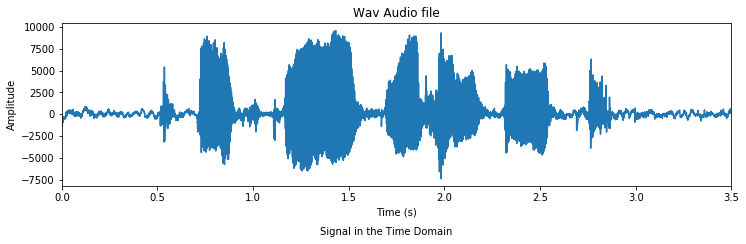

In [195]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io.wavfile
from scipy.fftpack import dct
import IPython.display as ipd
import matplotlib.cm as cm
import librosa
import librosa.display

# Specify the preferred size of the plots
plt.rcParams['figure.figsize'] = [12, 3]

def load_wav_file(wav_file, start=None, end=None):
    '''
    This function loads a wav file and returns
    the sample_rate and signal. If start and end
    is not specified then the whole wav_file is loaded.
    If start and end is specified then only a subset of
    this signal is returned. Start and end are specified 
    in terms of seconds.
    '''
    
    sample_rate, signal = scipy.io.wavfile.read(wav_file)
    
    if start is None and end is None:
        return [sample_rate, signal]
    
    if start is not None and end is not None:
        signal = signal[int(start * sample_rate):int(end * sample_rate)]
        return [sample_rate, signal]
    
    if start is not None and end is None:
        signal = signal[int(start * sample_rate):]
        return [sample_rate, signal]
    
    if start is None and end is not None:
        signal = signal[:int(end * sample_rate)]
        return [sample_rate, signal]



WAV_FILE = 'data/OSR_us_000_0010_8k.wav'
WAV_START = 0
WAV_END = 3.5



sample_rate, signal = load_wav_file(WAV_FILE, start=WAV_START, end=WAV_END)

print("Sampling frequency: {} Hz".format(sample_rate))

# Plotting the signal
fig = plt.figure()
fig.text(.5, -0.1, "Signal in the Time Domain", ha='center')

# To Plot the x-axis in seconds you need get the 
# frame rate / sample rate and divide by size of your signal
time = np.arange(len(signal))/float(sample_rate) 

plt.plot(time, signal)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("Wav Audio file")
plt.xlim([WAV_START, WAV_END])
plt.show()

In [150]:
# Original file.
ipd.Audio(WAV_FILE)

In [197]:
# Loaded subset signal
# It sounds worse than the original data maybe because
# there is an error in float/int conversion?
# Do I have to convert the signal to a certain range before playing?
ipd.Audio(signal, rate=sample_rate)

### 1.2 Pre-Emphasis

It seems that Pre-Emphasis is not really required in modern Speech Recognition Systems anymore. An explanation can be found here: Why is pre-emphasis (i.e. passing the speech signal through a first order high pass filter) required in speech processing and how does it work? - https://www.quora.com/Why-is-pre-emphasis-i-e-passing-the-speech-signal-through-a-first-order-high-pass-filter-required-in-speech-processing-and-how-does-it-work/answer/Nickolay-Shmyrev?srid=e4nz&share=71ca3e28 

_Pre-emphasis is a very simple signal processing method which increases the amplitude of high frequency bands and decrease the amplitudes of lower bands. In simple form it can be implemented as_

\begin{align}
y_t = x_t - \alpha x_{t-1}
\end{align}

_Pre-emphasis is not really required, it was introduced many years ago when limited computing resources forced developers to create tricky methods. It was noted that higher frequencies are more important for signal disambiguation than lower frequencies. In those days it would be easier to apply analog preemphasis filter to get slightly better results so the pre-emphasis become popular. Another good property of preemphasis is that it helps to deal with DC offset which is often present in recordings and thus it can improve energy-based voice activity detection._

_Modern speech recognition do not require pre-emphasis. Preemphasis is compensated on later stages with channel normalization like cepstral mean normalization so it should have no effect at all. It is an artifact from a older system design._

Typical values for the filter coefficient ($\alpha$) are 0.95 or 0.97.



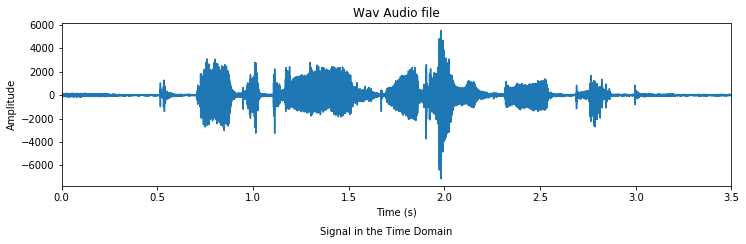

In [152]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

# Plotting the signal
fig = plt.figure()
fig.text(.5, -0.1, "Signal in the Time Domain", ha='center')

# To Plot the x-axis in seconds you need get the 
# frame rate / sample rate and divide by size of your signal
time = np.arange(len(emphasized_signal))/float(sample_rate) 

plt.plot(time, emphasized_signal)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("Wav Audio file")
plt.xlim([WAV_START, WAV_END])
plt.show()

In [75]:
# Loaded subset of emphasized signal
ipd.Audio(emphasized_signal, rate=sample_rate)

### 1.3 Framing

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

In [153]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

print("Frame length: {}".format(frame_length))
print("Number of frames: {}".format(len(frames)))

Frame length: 200
Number of frames: 348


In [98]:
ipd.Audio(frames[252], rate=sample_rate)

### 1.4 Window

* See also: https://en.wikipedia.org/wiki/Window_function
* https://dsp.stackexchange.com/questions/36513/applying-a-window-function-to-a-speech-signal
* http://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:

\begin{align}
w[n] = 0.54−0.46 \cos (\frac{2 \pi n}{N - 1})
\end{align}

where, $0 \leq n \leq N - 1, N$ is the window lenght. Plotting the previous equation yields the following plot:


Text(0.5,0,'Samples')

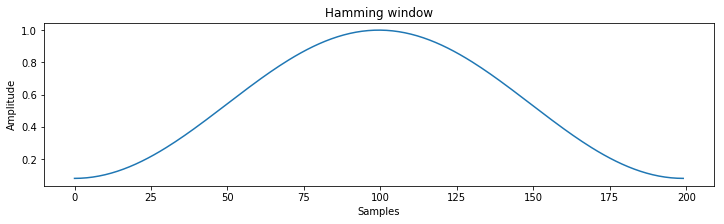

In [154]:
window = scipy.signal.hamming(200)
plt.plot(window)
plt.title("Hamming window")
plt.ylabel("Amplitude")
plt.xlabel("Samples")

There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.

In [155]:
frames *= np.hamming(frame_length)
# frames *= 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1))  # Explicit Implementation **

In [156]:
ipd.Audio(frames[252], rate=sample_rate)

### 1.5 Fourier-Transform and Power Spectrum

We can now do an $N$-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where $N$ is typically 256 or 512, $NFFT = 512$; and then compute the power spectrum (periodogram) using the following equation:

\begin{align}
P = \frac{|FFT(x_i)|^2}{N}
\end{align}

where, $x_i$ is the $i^{th}$ frame of signal $x$. This could be implemented with the following lines:

In [157]:
NFFT = 512

mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

### 1.6 Filter Banks

The final step to computing filter banks is applying triangular filters, typically 40 filters, $nfilt = 40$ on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz $(f)$ and Mel $(m)$ using the following equations:

\begin{align}
m = 2595 \log_{10} (1 + \frac{f}{700}) \\
f = 700(10^{m/2595} - 1)
\end{align}

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0, as shown in this figure:

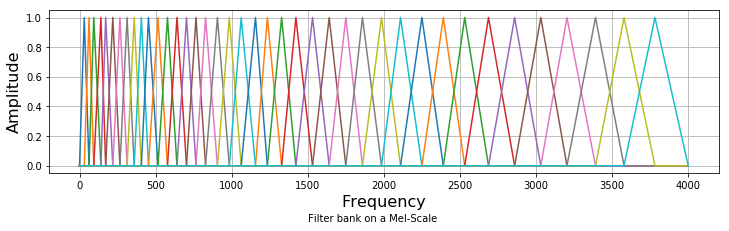

In [158]:
fig = plt.figure()
plt.plot(np.linspace(low_freq_mel, (sample_rate / 2), 257), fbank.T)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Frequency', fontsize=16)
plt.grid(True)
#plt.savefig('mel_filters.jpg', bbox_inches='tight', dpi=200)
fig.text(.5, -0.1, "Filter bank on a Mel-Scale", ha='center')
plt.show()

This can be modeled by the following equation:

\begin{align}
H_m(k) = \begin{cases}
               0 & k < f(m -1)\\
               \frac{k - f(m - 1)}{f(m) - f(m - 1)} & f(m - 1) \leq k < f(m)\\
               1 & k = f(m)\\
               \frac{f(m + 1) -k}{f(m + 1) - f(m)} & f(m) < k \leq f(m + 1)\\
               0 & k > f(m - 1)
            \end{cases}
\end{align}

In [159]:
nfilt = 40

low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

print(filter_banks.shape)

(348, 40)


After applying the filter bank to the power spectrum (periodogram) of the signal, we obtain the following spectrogram:

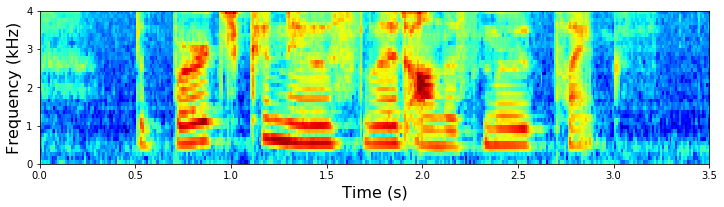

In [160]:
plt.imshow(np.flipud(filter_banks.T), cmap=cm.jet, aspect=0.2, extent=[WAV_START,WAV_END,0,4])
plt.ylabel('Frequency (kHz)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('filter_banks_raw.jpg', bbox_inches='tight', dpi=200)
plt.show()
 

If the Mel-scaled filter banks were the desired features then we can skip to mean normalization.

### 1.6 Mel-frequency Cepstral Coefficients (MFCCs)

It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; **num_ceps = 12**. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [161]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

<function matplotlib.pyplot.show>

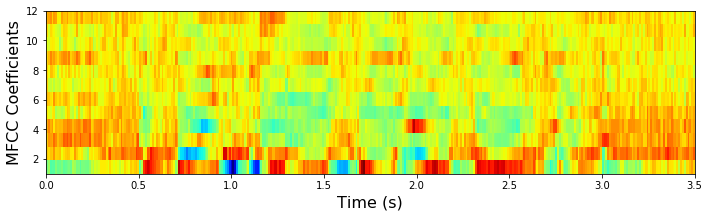

In [162]:
plt.imshow(np.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[WAV_START,WAV_END,1,num_ceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
#plt.savefig('mfcc_raw.jpg', bbox_inches='tight', dpi=200)
plt.show

One may apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.

In [163]:
cep_lifter = 22

# Lifter
if cep_lifter > 0:
    (nframes, ncoeff) = numpy.shape(mfcc)
    n = numpy.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    mfcc *= lift

<function matplotlib.pyplot.show>

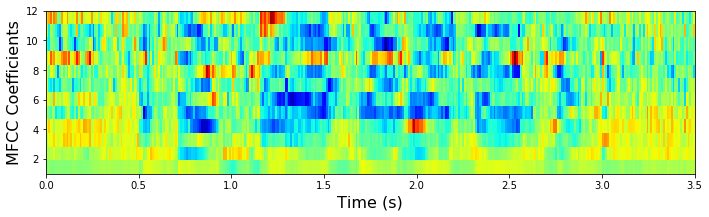

In [164]:
plt.imshow(np.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[WAV_START,WAV_END,1,num_ceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
#plt.savefig('mfcc_liftered.jpg', bbox_inches='tight', dpi=200)
plt.show

### 1.7 Mean Normalization

As previously mentioned, to balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.

In [165]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

The mean-normalized filter banks:

<function matplotlib.pyplot.show>

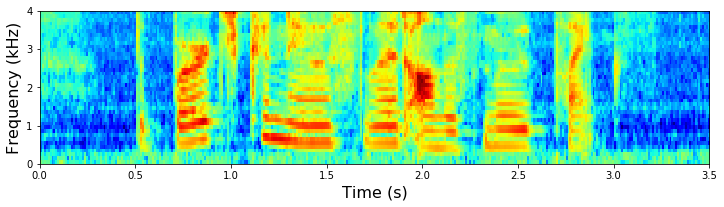

In [166]:
plt.imshow(np.flipud(filter_banks.T), cmap=cm.jet, aspect=0.2, extent=[WAV_START,WAV_END,0,4])
plt.ylabel('Frequency (kHz)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
#plt.savefig('filter_banks.jpg', bbox_inches='tight', dpi=200)
plt.show

and similarly for MFCCs:

In [167]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

The mean-normalized MFCCs:

<function matplotlib.pyplot.show>

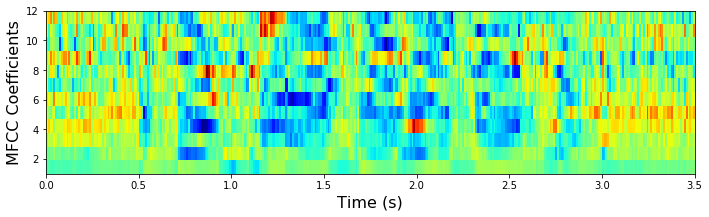

In [169]:
plt.imshow(np.flipud(mfcc.T), cmap=cm.jet, aspect=0.08, extent=[WAV_START,WAV_END,1,num_ceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
#plt.savefig('mfcc.jpg', bbox_inches='tight', dpi=200)
plt.show

## 2. Extracting Filter banks and MFCCs by using the librosa library

### 2.1 Loading the Wav file

In [204]:
# sr=None means: give me the native sample rate of the file 
# otherwise it is set to 22050 Hz 
x, sr = librosa.load(WAV_FILE, sr=None) 

sliced_x = x[int(WAV_START * sr):int(WAV_END * sr)]

print("Shape of the signal: {}".format(x.shape))
print("Sampling rate/ Sampling frequency: {}".format(sr))

Shape of the signal: (268985,)
Sampling rate/ Sampling frequency: 8000


Plot the audio array using librosa:

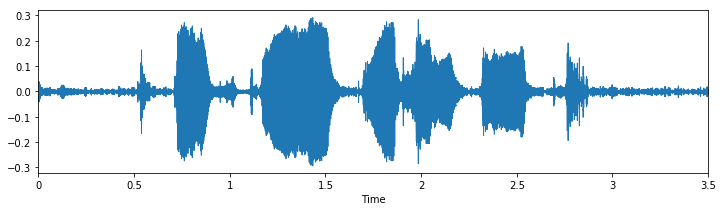

In [205]:
plt.figure()
librosa.display.waveplot(sliced_x, sr=sr)
plt.show()

Display a spectogram:

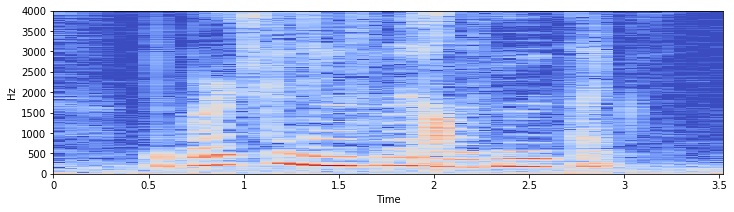

In [206]:
X = librosa.stft(sliced_x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure()
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [207]:
ipd.Audio(sliced_x, rate=sr)

**Audio** can also accept a NumPy array. Let's synthesize a pure tone at 440 Hz:

In [218]:
syn_sr = 22050 # sample rate
syn_T = 2.0    # seconds
syn_t = np.linspace(0, syn_T, int(syn_T*syn_sr), endpoint=False) # time variable
syn_x = 0.5*np.sin(2*numpy.pi*440*syn_t)                # pure sine wave at 440 Hz

In [219]:
ipd.Audio(syn_x, rate=syn_sr) # load a NumPy array

**librosa.feature.mfcc** computes MFCCs across an audio signal:

In [223]:
librosa_mfccs = librosa.feature.mfcc(sliced_x, sr=sr)
print("mfcc computed {} MFCCS over {} frames".format(librosa_mfccs.shape[0], librosa_mfccs.shape[1]))

mfcc computed 20 MFCCS over 55 frames


Display the MFCCs:

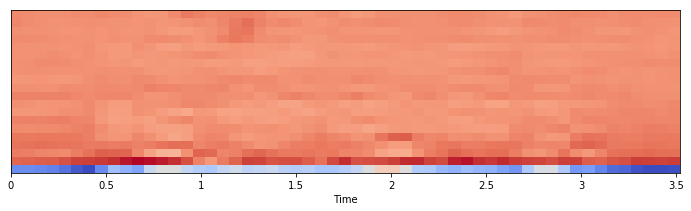

In [224]:
librosa.display.specshow(librosa_mfccs, sr=sr, x_axis='time')